In [24]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Taxi environment
env = gym.make("Taxi-v3",render_mode='ansi')
env.reset()
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




No Learning Code:

In [25]:
env.reset()

steps = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info, _ = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    steps += 1
    
print("Timesteps taken: {}".format(steps))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 449
Penalties incurred: 138


In [26]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 449
State: 475
Action: 5
Reward: 20


Monte Carlo

In [27]:
def monte_carlo(env, num_episodes, gamma=1.0):
    returns_sum = {}
    returns_count = {}
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    cumulative_rewards = []

    for i_episode in range(1, num_episodes + 1):
        state = env.reset()[0]
        episode = []
        while True:
            action = np.random.choice(np.arange(env.action_space.n))
            next_state, reward, done, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done or truncated:
                break

        cumulative_reward = 0
        for state, action, reward in episode[::-1]:
            cumulative_reward = gamma * cumulative_reward + reward
            sa_pair = (state, action)
            if sa_pair not in [(x[0], x[1]) for x in episode[:-1]]:
                if sa_pair not in returns_sum:
                    returns_sum[sa_pair] = 0
                    returns_count[sa_pair] = 0
                returns_sum[sa_pair] += cumulative_reward
                returns_count[sa_pair] += 1
                Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        cumulative_rewards.append(sum([x[2] for x in episode]))

    return Q, cumulative_rewards

Q-Learning

In [28]:
def q_learning(env, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    cumulative_rewards = []

    for i_episode in range(1, num_episodes + 1):
        state = env.reset()[0]
        cumulative_reward = 0

        while True:
            if np.random.rand() < epsilon:
                action = np.random.choice(np.arange(env.action_space.n))
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, truncated, _ = env.step(action)
            cumulative_reward += reward

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            state = next_state

            if done or truncated:
                break

        cumulative_rewards.append(cumulative_reward)

    return Q, cumulative_rewards

Training

In [30]:
num_episodes = 3000
Q_mc, mc_rewards = monte_carlo(env, num_episodes)
Q_ql, ql_rewards = q_learning(env, num_episodes)
print("Done")

Done


Plotting

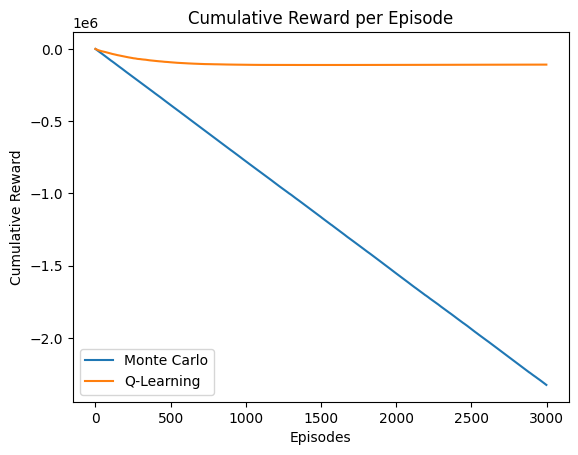

In [31]:
plt.plot(range(num_episodes), np.cumsum(mc_rewards), label='Monte Carlo')
plt.plot(range(num_episodes), np.cumsum(ql_rewards), label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode')
plt.legend()
plt.show()